###### Content under Creative Commons Attribution license CC-BY 4.0, code under MIT license (c)2015 J.M. Kerwin. Style from Numerical-MOOC (c)2014 L.A. Barba, G.F. Forsyth also under CC-BY.

In [69]:
%matplotlib inline
import numpy 
from sympy import *
from matplotlib import pyplot
import matplotlib.pyplot as plt
from matplotlib import rcParams
import webbrowser
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

# DC Motor Control

Welcome to the *proposed* bonus notebook for the first learning module of the course [**"Practical Numerical Methods with Python."**](http://openedx.seas.gwu.edu/courses/GW/MAE6286/2014_fall/about)

In this notebook I discuss an application of ordinary differential equation (ODE) methods to DC motor control for a gimbal system. The focus is the motion profile and motor winding temperature with a demand current input. Here is a great general overview of [DC Motor Theory](http://hades.mech.northwestern.edu/index.php/Brushed_DC_Motor_Theory) relating specifically to the Maxon motors presented in this excersize.

What is a gimbal? It is a device for controlling rotation around an axis. The most common example is in a pan-tilt security camera, which is a two-stage gimbal. For a general description of a gimbal, reference ["Gimbal-Wikipedia."](https://en.wikipedia.org/wiki/Gimbal) A linear and rotary positioning machine manufacturer, [Newmark Systems](http://www.newmarksystems.com/gimbal-mounts/), shows a great example of a moving two-stage gimbal in the video below. The azimuth stage is represented by rotation about the vertical axis, and the elevation stage is represented by rotation about a horizontal axis. Note the cube DC stepper motors mounted to each of the stages and the external cables connected bewteen the first and second stage indicating that the azimuth stage has a limitied rotation of about 360 degrees.


In [70]:
from IPython.display import YouTubeVideo
YouTubeVideo('wOK12HZSbu4')

The gimbal and payload specifications for this excersize are as follows:

**Payload Specification**
* Dimensions: $48x11x7 in.$
* Mass moment of inertia for the Azimuth Stage: $26.831 kgm^2$
* The Speed reducing, Torque increasing Drive Ratio for this setup is 300:1

**[Maxon Motor](http://www.maxonmotorusa.com) hardware**
* Maxon EPOS2 70/10 controller part number 375711
* Maxon Planetary gearhead GP62A with 100:1 gear ratio part number 110505
* Maxon EC45 DC brushless motor part number 136210
* $V_\rm{applied}=28Volts$
* $I_\rm{max}=25Amps$
* $P_\rm{max}=500Watts$


In [71]:
# Open the PDFs for the Maxon Equipment
webbrowser.open_new('Maxon_375711.pdf');
webbrowser.open_new('Maxon_110505.pdf');
webbrowser.open_new('Maxon_136210.pdf');

**Functional Requirements**
* Determine Acceleration Profile
* Determine Velocity Profile
* Determine Position Profile
* Determine the Input Current profile for starting at 0 Degrees and stopping at 360 degrees, model as a constant step function
* Determine the time to complete the rotation
* Determine maximum motor winding temperature

**Environmental Factors**
* Operate during a wind velocity of 155 knots - The estimated wind induced torque is modeled after an [ICAS](http://www.icas.org) research paper on rectangular prisms as airfoils.

## Derivation of Equations

In [72]:
#Reference Maxon Motor Theory for Equations and Principles
webbrowser.open_new('Maxon_Motor_Notes.pdf');
webbrowser.open_new('Maxon_Motor_Technical_Equations.pdf');


**Conservation of Power**

Mechanical power in the form of torque times angular velocity is induced from the applied motor current and voltage. 
$$Power_\rm{mechanical} = I_\rm{applied}V_\rm{induced} = \tau_\rm{motor}\omega$$

Losses exist in the form of resistance (heat) and inductance (delay)...
$$V_\rm{applied} = V_\rm{induced}+RI_\rm{applied}+L\frac{dI}{dt}$$

Solving for $V_\rm{induced}$ and substituting into the power equation...
$$I_\rm{applied}(V_\rm{applied}-RI_\rm{applied}-L\frac{dI}{dt}) = \tau_\rm{motor}\omega$$

The inductance value for this motor is $0.0565 mH$. Limiting the applied current ramp rate to $1000Amps$ per second will keep any inductance effects lower than $0.0565 Volts$. With an applied motor voltage of $28 Volts$, this is less than $0.2$ percent. Therefore the $LdI/dt$ term can be neglected and removed from the equation. This is consistent with accepted practice for DC motors.

$$I_\rm{applied}(V_\rm{applied}-RI_\rm{applied}) = \tau_\rm{motor}\omega$$

Total torque is a combination of motor torque and external input torque due to a wind induced moment (yaw moment for the azimuth stage).
$$\tau_\rm{total} = \tau_\rm{motor}+\tau_\rm{environmental} = I_\rm{inertia}\alpha$$

Solving for $\tau_\rm{motor}$ and substituting into the power equation...
$$I_\rm{applied}(V_\rm{applied}-RI_\rm{applied}) = (I_\rm{inertia}\alpha-\tau_\rm{environmental})\omega$$

This is the controlling equation for motion of the gimbal azimuth stage.  Let's rearrange and solve for $\alpha$.
$$\alpha = \frac{I_\rm{applied}(V_\rm{applied}-RI_\rm{applied})}{I_\rm{inertia}\omega}-\frac{\tau_\rm{environmental}}{I_\rm{inertia}}$$

Now let's rearrange into a derivative form...
$$ \frac{\omega^{n+1}-\omega^n}{\Delta t}= \frac{I_\rm{applied}(V_\rm{applied}-RI_\rm{applied})}{I_\rm{inertia}\omega^n}-\frac{\tau_\rm{environmental}}{I_\rm{inertia}}$$

Solving for $\omega^{n+1}$
$$ \omega^{n+1}= \omega^n+\Delta t(\frac{I_\rm{applied}(V_\rm{applied}-RI_\rm{applied})}{I_\rm{inertia}\omega^n}-\frac{\tau_\rm{environmental}}{I_\rm{inertia}})$$

**Motor Winding Temperature**

Motor winding resistance is a function of temperature and represented by
$$R_\rm{T}= R_\rm{25}(1+\alpha_\rm{cu}(T-25^{\circ}C))$$

Where the thermal resistance coefficent for copper is $\alpha_\rm{cu} =0.0039$

Using a [time constant LTI system differential equation](https://en.wikipedia.org/wiki/Time_constant) as a basis for the thermal equation for the motor winding temperature
$$\frac{\Delta T}{dt} + \frac{T-25^{\circ}C}{\tau} = R_\rm{thermal}I_\rm{applied}^2R_\rm{T}$$

Where the thermal resistance for the housing and windings is $R_\rm{thermal} = (1.7+1.1)^{\circ}K/Watt$ and the thermal time constant $\tau=31seconds$

Substituting the $R_\rm{T}$ into the LTI equation
$$\frac{\Delta T}{dt} + \frac{T-25^{\circ}C}{\tau} = R_\rm{thermal}I_\rm{applied}^2(R_\rm{25}(1+\alpha_\rm{cu}(T-25^{\circ}C)))$$

Solving for $\Delta T$ and arranging in derivative form
$$\frac{T^{n+1}-T^n}{\Delta t}  = R_\rm{thermal}I_\rm{applied}^2(R_\rm{25}(1+\alpha_\rm{cu}(T^n-25^{\circ}C)))- \frac{T^n-25^{\circ}C}{\tau}$$

Solving for $T^{n+1}$
$$T^{n+1}  = T^n+\Delta t(R_\rm{thermal}I_\rm{applied}^2(R_\rm{25}(1+\alpha_\rm{cu}(T^n-25^{\circ}C)))- \frac{T^n-25^{\circ}C}{\tau})$$

**Environmental Torque**

In [73]:
#Open the PDF for the ICAS 155 Airfoil Paper for yaw moment approximations
webbrowser.open_new('International_council_of_aeronautical_sciences155.pdf');

The estimated wind induced torque as a function of payload roation angle for a a 3D rectangular prism body is calculated using equation 7 in the ICAS 155 paper above. The yaw moment coefficient is then combined with a wind pressure, area and chord length to achieve an estimated yaw moment. This equation does not require a derived numerical solution.

$$\tau_\rm{environmental} = (0.09(1-(\frac{Width}{Length})^2)sin(2\theta_\rm{payload})-.04*\frac{Width}{Length}sin(4\theta_\rm{payload}))*0.00256V^2A_\rm{face}L_\rm{chord}$$
    

## Let the Coding Begin

Now that the equations are in order, let's setup the demand current and voltage profiles. The current profile is a ramped square wave current input. The voltage is mapped after the current profile with a maximum of $28 Volts$ and a power maximum of $IV = 500 Watts$.

In [74]:
def Ivalues(Imax,Itimemax,Icontinuous,Iramprate,Itimecontinuous,N):
    I = numpy.zeros(N)
    I[:] = Icontinuous
    I[0] = 0.0
    for i in range(1,T1): #ramp up
        I[i] = Iramprate*(dt*i)
    for i in range(T1,T2): #dwell at max
        I[i] = Imax
    for i in range(T2,T3): #ramp down
        I[i] = Imax - Iramprate*(dt*(i-T2))
    for i in range(T3,T4): #dwell at continuous
        I[i] = Icontinuous
    for i in range(T4,T5): #ramp up
        I[i] = Icontinuous - Iramprate*(dt*(i-T4))
    for i in range(T5,T6): #dwell at max
        I[i] = -Imax
    for i in range(T6,T7): #ramp down
        I[i] = -Imax + Iramprate*(dt*(i-T6)) 
    return I[:]

In [75]:
def Vvalues(I,N):
    V = numpy.zeros(N)
    V[:]=0.0
    for i in range(0,N):
        if I[i]==0:
            V[i]=28
        elif abs(500/I[i])>28:
            V[i]=28
        else:
            V[i]=abs(500/I[i] )  
    return V[:]

The total Time is intentionally longer than the expect slew time of $0^{\circ}$ to $360^{\circ}$ to allow for capturing the full temperature decay profile of the motor winding. A $\Delta t$ of $0.0001 Seconds$ is chosen based on the maximum ramp rate of the demand current $1000Amps/Second$ (the demand current changes no more than $.1Amps/\Delta t$) and the processing time required for a smaller $\Delta t$. Values marked with a triple comment (###) are pulled directly from the Maxon motor specifications and equations cited above.

In [76]:
#Intitial setup
T = 100
dt = 0.0001
N = int(T/dt)+1
t = numpy.linspace(0.0, T, N)

R = 0.143 ###Ohms
Ratio = 300 # Speed Reducing Ratio
Inertia = 26.831/Ratio #kg-m^2 Payload inertia 

Rthermal = 1.7+1.1 ###Degrees K per Watt
acu = 0.0039 ###thermal resistance coefficeint for copper
Tamb = 25 #degrees C
Thermaltimeconstant =31 ###seconds

#Payload specs for TAUenvironmental
Windspeed = 155*1.1508 #MPH
Length = 7/12 #feet
Width = 48/12 #feet
Height = 11/12 #feet

Imax = 500/28 #Amps
Itimemax = 5.6458 #Seconds 5.6458
Icontinuous = 0.0 #Amps
Iramprate = 1000 #Amps/Second
Itimecontinuous = 0.0 #seconds

T1 =      int((Imax/Iramprate)/dt) #ramp up
T2 = T1 + int(Itimemax/dt) #dwell at max
T3 = T2 + int(((Imax-Icontinuous)/Iramprate)/dt) #ramp down
T4 = T3 + int(Itimecontinuous/dt) #dwell at continuous
T5 = T4 + int(((Imax-Icontinuous)/Iramprate)/dt) #ramp up
T6 = T5 + int(Itimemax/dt) #dwell at max
T7 = T6 + int(((Imax-Icontinuous)/Iramprate)/dt) #ramp down

#Initial Conditions
I = Ivalues(Imax,Itimemax,Icontinuous,Iramprate,Itimecontinuous,N) 
V = Vvalues(I,N)
alpha = numpy.zeros(N)
alpha[:] = 0.0#radians/second^2
omega = numpy.zeros(N)
omega[:] = 0.001 #radians/second, note that the initial speed must be greater than 0 to kickstart the numerical solution
theta = numpy.zeros(N)
theta[:] = 0.0#radians
temp = numpy.zeros(N)
temp[:] = 25 #degrees C
TAUenv = numpy.zeros(N)
TAUenv[:] = 0#Newtons-meters

## Numerical Method: Can a Punctuation Mark have Alliteration?

A two-stage second-order Runge-Kutta Ralston Method is used to numerically solve the rotational velocity and motor winding temperature profiles. The choice of method gives a second order of convergence and presents a comparison of methods by building upon the first order Euler method in the first stage of the solution.

In [77]:
#Using a two-stage second-order Runge-Kutta Ralston Method
omegaEU=omega.copy()
omegastarRK2Ralston=omega.copy()
omegaRK2Ralston=omega.copy()
tempEU=temp.copy()
tempstarRK2Ralston=temp.copy()
tempRK2Ralston=temp.copy()

for n in range(1,N):       
    #Euler Method
    omegaEU[n] = omegaEU[n-1] + dt*(I[n-1]*(V[n-1]-(R*(1+acu*(tempRK2Ralston[n-1]-Tamb)))*I[n-1])/(Inertia*omegaEU[n-1]) +TAUenv[n-1]/Inertia)
    #Runge-Kutta 2 Ralston Method
    omegastarRK2Ralston[n] = omegaRK2Ralston[n-1] + (2/3)*dt*(I[n-1]*(V[n-1]-(R*(1+acu*(tempRK2Ralston[n-1]-Tamb)))*I[n-1])/(Inertia*omegaRK2Ralston[n-1]) +TAUenv[n-1]/Inertia)
    omegaRK2Ralston[n] = omegaRK2Ralston[n-1] + dt*(I[n-1]*(V[n-1]-(R*(1+acu*(tempRK2Ralston[n-1]-Tamb)))*I[n-1])/(Inertia*omegastarRK2Ralston[n-1]) +TAUenv[n-1]/Inertia)       
    
    #Direct Deriviative and Integral
    theta[n] = theta[n-1] + dt*omegaRK2Ralston[n-1]
    alpha[n] = (omegaRK2Ralston[n]-omegaRK2Ralston[n-1])/dt
    
    #Euler Method
    tempEU[n] = tempEU[n-1] + dt*(Rthermal*abs(I[n-1])*(R*(1+acu*(tempEU[n-1]-Tamb)))-tempEU[n-1]/Thermaltimeconstant+Tamb/Thermaltimeconstant)
    #Runge-Kutta 2 Ralston Method
    tempstarRK2Ralston[n] = tempRK2Ralston[n-1] + (2/3)*dt*(Rthermal*abs(I[n-1])*(R*(1+acu*(tempRK2Ralston[n-1]-Tamb)))-tempRK2Ralston[n-1]/Thermaltimeconstant+Tamb/Thermaltimeconstant)
    tempRK2Ralston[n] = tempRK2Ralston[n-1] + dt*(Rthermal*abs(I[n-1])*(R*(1+acu*((1/4*tempEU[n-1]+3/4*tempstarRK2Ralston[n-1])-Tamb)))-(1/4*tempEU[n-1]+3/4*tempstarRK2Ralston[n-1])/Thermaltimeconstant+Tamb/Thermaltimeconstant)
    
    #Equation
    TAUenv[n] = -((0.09*(1-(Width/Length)**2)*numpy.sin(2*theta[n]/Ratio)-.04*(Width/Length)*numpy.sin(4*theta[n]/Ratio))*((Windspeed)**2)*.00256*Width*Height*Length)*1.355818/Ratio
    
    if theta[n]>=2*numpy.pi*Ratio:
        theta[n:] = theta[n]
        timestamp = (n)*dt
        break
        
#Continues solution out to full T time to capture temperature decay
for n in range(int(timestamp/dt),N):
    #Euler Method
    tempEU[n] = tempEU[n-1] + dt*(Rthermal*abs(0)*(R*(1+acu*(tempEU[n-1]-Tamb)))-tempEU[n-1]/Thermaltimeconstant+Tamb/Thermaltimeconstant)
    #Runge-Kutta 2 Ralston Method
    tempstarRK2Ralston[n] = tempRK2Ralston[n-1] + (2/3)*dt*(Rthermal*abs(0)*(R*(1+acu*(tempRK2Ralston[n-1]-Tamb)))-tempRK2Ralston[n-1]/Thermaltimeconstant+Tamb/Thermaltimeconstant)
    tempRK2Ralston[n] = tempRK2Ralston[n-1] + dt*(Rthermal*abs(0)*(R*(1+acu*((1/4*tempEU[n-1]+3/4*tempstarRK2Ralston[n-1])-Tamb)))-(1/4*tempEU[n-1]+3/4*tempstarRK2Ralston[n-1])/Thermaltimeconstant+Tamb/Thermaltimeconstant)
T = timestamp
print('The L-1 norm error between the Euler method and the Ralston Method for a delta t of',dt,'Seconds is an Omega error of', round(dt*numpy.sum(numpy.abs(omegaEU-omegaRK2Ralston)*180/numpy.pi),3),'Degrees/Second and a Temperature error of',round(dt * numpy.sum(numpy.abs(tempEU-tempRK2Ralston)),3), 'Degrees C.');

The L-1 norm error between the Euler method and the Ralston Method for a delta t of 0.0001 Seconds is an Omega error of 3.195 Degrees/Second and a Temperature error of 0.001 Degrees C.


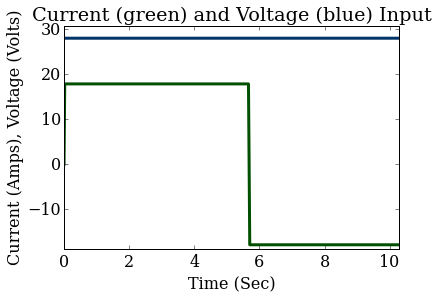

In [78]:
pyplot.plot(t, I, color='#005000', ls='-', lw=3)
pyplot.plot(t, V, color='#003366', ls='-', lw=3)
pyplot.title('Current (green) and Voltage (blue) Input')
pyplot.ylabel('Current (Amps), Voltage (Volts)')
pyplot.xlabel('Time (Sec)')
pyplot.xlim(0,T);
pyplot.ylim(numpy.amin(I)*1.05,numpy.amax(V)*1.1);

Maximum Environmental Torque on the motor is 3.289 Newton-Meters with a windspeed of 178 MPH.


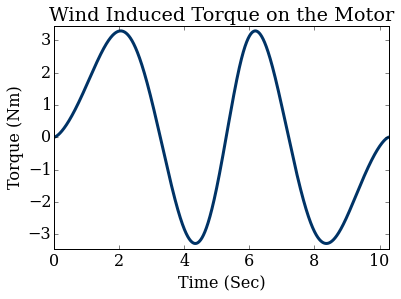

In [79]:
'''pyplot.figure(1);
pyplot.plot(t, TAUenv*Ratio, color='#003366', ls='-', lw=3);
pyplot.title('Wind Induced Torque on the Payload');
pyplot.ylabel('Torque (Nm)');
pyplot.xlabel('Time (Sec)');
pyplot.xlim(0,T);
pyplot.ylim(numpy.amin(TAUenv*Ratio)*1.05,numpy.amax(TAUenv*Ratio)*1.05);
'''
pyplot.figure(2);
pyplot.plot(t, TAUenv, color='#003366', ls='-', lw=3);
pyplot.title('Wind Induced Torque on the Motor');
pyplot.ylabel('Torque (Nm)');
pyplot.xlabel('Time (Sec)');
pyplot.xlim(0,T);
pyplot.ylim(numpy.amin(TAUenv)*1.05,numpy.amax(TAUenv)*1.05);
print('Maximum Environmental Torque on the motor is', round(numpy.amax(abs(TAUenv)),3),'Newton-Meters with a windspeed of',round(Windspeed), 'MPH.');

Final Payload Rotation angle is 360.0 Degrees


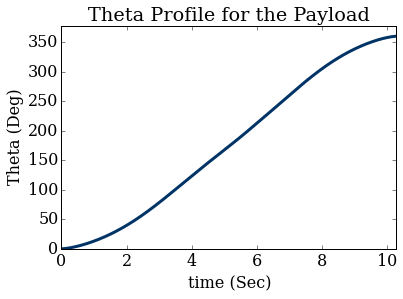

In [80]:
'''
pyplot.figure(1);
pyplot.plot(t, theta*180/numpy.pi, color='#003366', ls='-', lw=3);
pyplot.title('Theta Profile for the Motor');
pyplot.ylabel('Theta (Deg)');
pyplot.xlabel('Time (Sec)');
pyplot.xlim(0,T);
pyplot.ylim(0,numpy.amax(theta)*180/numpy.pi*1.05);
'''
pyplot.figure(2);
pyplot.plot(t, theta*180/numpy.pi/Ratio, color='#003366', ls='-', lw=3);
pyplot.title('Theta Profile for the Payload');
pyplot.ylabel('Theta (Deg)');
pyplot.xlabel('time (Sec)');
pyplot.xlim(0,T);
pyplot.ylim(0,numpy.amax(theta)*180/numpy.pi/Ratio*1.05);
print('Final Payload Rotation angle is', round(numpy.amax(abs(theta)*180/numpy.pi/Ratio),3),'Degrees');

Maximum Payload Rotational Velocity is 48.035 Degrees/Second


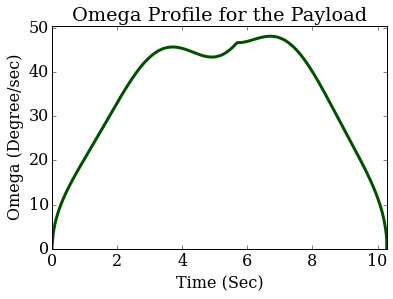

In [81]:
'''
pyplot.figure(1);
pyplot.plot(t, omegaRK2Ralston*180/numpy.pi, color='#005000', ls='-', lw=3)
pyplot.title('Omega Profile for the Motor')
pyplot.ylabel('Omega (Degree/sec)')
pyplot.xlabel('Time (Sec)')
pyplot.xlim(0,T);
pyplot.ylim(0,numpy.amax(omegaRK2Ralston)*180/numpy.pi*1.05);
'''
pyplot.figure(2);
pyplot.plot(t, omegaRK2Ralston*180/numpy.pi/Ratio, color='#005000', ls='-', lw=3)
pyplot.title('Omega Profile for the Payload')
pyplot.ylabel('Omega (Degree/sec)')
pyplot.xlabel('Time (Sec)')
pyplot.xlim(0,T);
pyplot.ylim(0,numpy.amax(omegaRK2Ralston)*180/numpy.pi/Ratio*1.05);
print('Maximum Payload Rotational Velocity is', round(numpy.amax(abs(omegaRK2Ralston)*180/numpy.pi/Ratio),3),'Degrees/Second');

Maximum Payload Rotational Acceleration is 5976.156 Degrees/Second^2 with a maximum sustained acceleration of 12.602 Degrees/Second^2


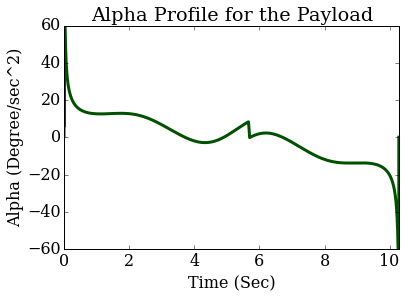

In [82]:
'''
pyplot.figure(1);
pyplot.plot(t, alpha*180/numpy.pi, color='#005000', ls='-', lw=3)
pyplot.title('Alpha Profile for the Motor')
pyplot.ylabel('Alpha (Degree/sec^2)')
pyplot.xlabel('Time (Sec)')
pyplot.xlim(0,T);
pyplot.ylim(-numpy.amax(alpha)*180/numpy.pi*.01,numpy.amax(alpha)*180/numpy.pi*.01);
'''
pyplot.figure(2);
pyplot.plot(t, alpha*180/numpy.pi/Ratio, color='#005000', ls='-', lw=3)
pyplot.title('Alpha Profile for the Payload')
pyplot.ylabel('Alpha (Degree/sec^2)')
pyplot.xlabel('Time (Sec)')
pyplot.xlim(0,T);
pyplot.ylim(-numpy.amax(alpha)*180/numpy.pi/Ratio*.01,numpy.amax(alpha)*180/numpy.pi/Ratio*.01);
print('Maximum Payload Rotational Acceleration is', round(numpy.amax(abs(alpha)*180/numpy.pi/Ratio),3),'Degrees/Second^2 with a maximum sustained acceleration of',round((alpha[int(1/dt)]*180/numpy.pi/Ratio+alpha[int(1.5/dt)]*180/numpy.pi/Ratio+alpha[int(2/dt)]*180/numpy.pi/Ratio)/3,3),'Degrees/Second^2');

Maximum Motor Winding Temeprature is 96.67 Degrees C after 10.2803 Seconds of operation at a current of 17.857 Amps and 28.0 Volts with an ambient temperature of 25 degrees C.


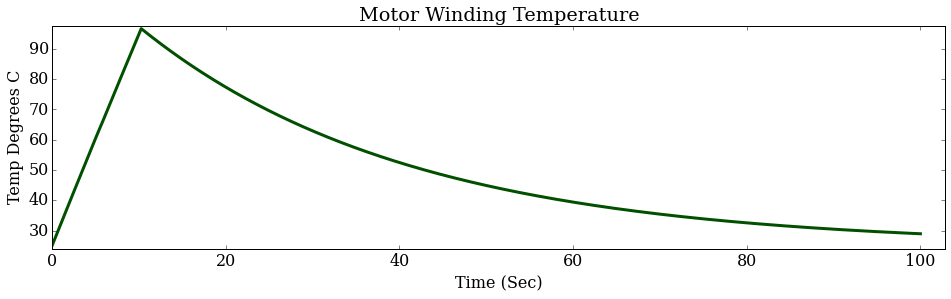

In [83]:
pyplot.figure(1, figsize=(16,4));
pyplot.plot(t, tempRK2Ralston, color='#005000', ls='-', lw=3);
pyplot.title('Motor Winding Temperature');
pyplot.ylabel('Temp Degrees C');
pyplot.xlabel('Time (Sec)');
pyplot.xlim(0,T*10);
pyplot.ylim(numpy.amin(tempRK2Ralston)-1,numpy.amax(tempRK2Ralston)+1);
print('Maximum Motor Winding Temeprature is', round(numpy.amax(abs(tempRK2Ralston)),3),'Degrees C after', round(T,4), 'Seconds of operation at a current of', round(Imax,3),'Amps and',numpy.amax(V),'Volts with an ambient temperature of',Tamb,'degrees C.' );

###### The cell below loads the style of this notebook.

In [ ]:
from IPython.core.display import HTML
css_file = 'styles/numericalmoocstyle.css'
HTML(open(css_file, "r").read())